Testing Sci-kit Learn AUC function

In [ ]:
import os
import numpy as np
import cv2 as cv
from ultralytics import YOLO
import numpy as np
from ultralytics.engine.results import Results
import torch

In [23]:
# Janky Letter classifier dupe bc python 3.10 vs 3.8
# from letter_classifier import LetterClassifier
CURRENT_FILE_PATH_let = os.path.dirname("C:\\Users\\brand\\OneDrive\\Documents\\UAV Forge\\uavf_2024\\uavf_2024\\imaging\\AUC_heuristic.ipynb")

class LetterClassifier:
    def __init__(self, img_size):
        self.model = YOLO(f'{CURRENT_FILE_PATH_let}/letter_classification/weights/letter.pt')

        rand_input = np.random.rand(1, img_size, img_size, 3).astype(np.float32)
        self.model.predict(list(rand_input), verbose=False)
    
    def predict(self, imgs):
        '''
        Returns MxN array of class probabilities
        M: number of images
        N: number of classes
        For example you can process 3 images at once and get back a 3x26 array where each image has its own array of class probabilities
        '''
        imgs = [np.repeat(img[...,np.newaxis],3,axis=2) for img in imgs]
        raw_output = self.model.predict(imgs)
        output = [data.probs.data.numpy() for data in raw_output]
        return output

In [98]:
# from letter_tests.py
CURRENT_FILE_PATH = os.path.dirname("C:\\Users\\brand\\OneDrive\\Documents\\UAV Forge\\uavf_2024\\tests\\imaging\\l")
letter_size = 128
letter_classifier = LetterClassifier(letter_size)

def test_letter_classification():
    imgs_path = CURRENT_FILE_PATH + "/imaging_data/letter_dataset/images"
    labels_path = CURRENT_FILE_PATH + "/imaging_data/letter_dataset/labels"
    total = 0
    correct = 0
    for img_file_name in os.listdir(imgs_path):
        img = cv.imread(f"{imgs_path}/{img_file_name}")
        raw_output = letter_classifier.model.predict(img)
        pred = np.argmax(raw_output[0].probs.data.numpy())
        with open(f"{labels_path}/{img_file_name.split('.')[0]}.txt") as f:
            truth = int(f.read(2))
        if truth == pred:
            correct += 1
        total += 1
        
        # print("hi", truth, pred)

    print(f"Letter only tests: {correct} out of {total}")
test_letter_classification()


Letter only tests: 2 out of 70


[       0.75           0           0        0.16        0.97        0.57        0.72        0.24        0.44        0.29        0.09         0.8           0        0.38        0.06        0.68        0.71        0.52        0.45        0.66        0.52        0.45        0.68        0.49           0        0.28
        0.32           0        0.96        0.32        0.09        0.53        0.01           0        0.26        0.49        0.47]


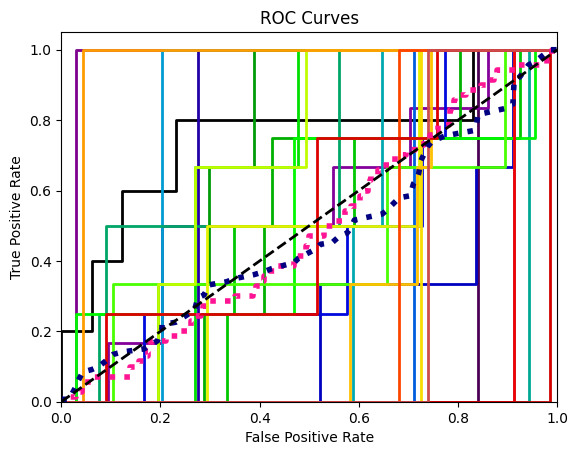

In [127]:
import scikitplot as skplt
import matplotlib.pyplot as plt


def run_letter_classification():
    imgs_path = CURRENT_FILE_PATH + "/imaging_data/letter_dataset/images"
    labels_path = CURRENT_FILE_PATH + "/imaging_data/letter_dataset/labels"

    y_probasA = []
    y_trueA = []
    for img_file_name in os.listdir(imgs_path):
        img = cv.imread(f"{imgs_path}/{img_file_name}")
        raw_output = letter_classifier.model.predict(img)
        pred = raw_output[0].probs.data.numpy()
        with open(f"{labels_path}/{img_file_name.split('.')[0]}.txt") as f:
            truth = int(f.read(2))
        
        y_trueA.append(truth)
        y_probasA.append(pred)
    return np.array(y_trueA), np.array(y_probasA)

y_true, y_probas = run_letter_classification()

def roc_auc(pred, truth):
    # pred: array of class probability dist for each image
    # truth: array of true labels for each image
    # Ex: pred = [[0.1, 0.2, 0.7], [0.3, 0.4, 0.3], [0.2, 0.5, 0.3]]
    #     truth = [2, 0, 1]
    # Required: Truth must have at least one instance of each class
    #   Ex: [0, 2, 3] is missing class 1
    # returns: np.array of AUC for each class, micro-average auc, macro-average auc
    

    # Need all classes to have at least one instance in validation dataset, so drop unused columns from pred and shift truth accordingly
    set_truth = set(truth)
    n = max(max(set_truth),pred.shape[1])
    drop_cols = [col for col in list(range(n)) if col not in set_truth]

    pred = np.delete(pred, drop_cols, axis=1) # drop columns from pred
    # adjust truth for dropped columns by shifting for each missing class
    adjust_map = dict() # {adjusted_truth : real truth class}
    for idx, col in enumerate(truth): 
        truth[idx] = col - sum(1 for drop_col in drop_cols if col > drop_col) 
        adjust_map[truth[idx]] = col

    # plot roc curve
    axes = skplt.metrics.plot_roc(truth, pred)
    legend = axes.get_legend().get_texts()              # list[Text('sample')]
    auc_strs = [clas.get_text() for clas in legend]     # Ex: 'ROC curve of class 2 (area = 0.97)', 'micro-average ROC curve (area = 0.49)'
    axes.get_legend().remove()

    # populate output array
    out = np.zeros(n+2)
    for text in auc_strs[:-2]:                          # populate auc for each class
        class_num = adjust_map[int(text.split(' ')[4])]
        auc = float(text.split(' ')[7][:-1])
        out[class_num] = auc
    # populate micro and macro averages
    out[-2] = float(auc_strs[-2].split(' ')[5][:-1])    # micro-average is at second to last index
    out[-1] = float(auc_strs[-1].split(' ')[5][:-1])    # macro-average is at last index

    return out, axes

temp = roc_auc(y_probas, y_true)
print(temp[0])




In [ ]:
# Example code working with scikitplot
# The usual train-test split mumbo-jumbo
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
nb = GaussianNB()
nb.fit(X_train, y_train)
predicted_probas = nb.predict_proba(X_test)

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()